# generate the tracks and blob energies from the truth information MC

In [1]:

import sys,os,os.path
sys.path.append("../../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'
from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

#import FOM_functions as FOM_func
#import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



from   matplotlib.animation import FuncAnimation
import matplotlib.pyplot    as     plt
import matplotlib.colors    as     colors
import matplotlib.cm        as     cm
from matplotlib.colors import Normalize

import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path



from IC.invisible_cities.cities.components import track_blob_info_creator_extractor
from IC.invisible_cities.io.hits_io        import load_hits
from IC.invisible_cities.io.hits_io        import hits_from_df, hitc_from_df
from IC.invisible_cities.core              import system_of_units as units
from IC.invisible_cities.types.symbols     import HitEnergy
from IC.invisible_cities.evm.event_model   import HitCollection
from IC.invisible_cities.evm.event_model   import Cluster
from IC.invisible_cities.evm.event_model   import Hit
from IC.invisible_cities.types.ic_types    import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from IC.invisible_cities.io.hits_io          import hits_writer
from IC.invisible_cities.core                import tbl_functions   as tbl
from IC.invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from IC.invisible_cities.io.hits_io          import hits_from_df
from IC.invisible_cities.evm.nh5             import HitsTable
from IC.invisible_cities.types.symbols       import NormStrategy
from IC.invisible_cities.types.ic_types      import NoneType
from IC.invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from IC.invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm

In [2]:


def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'MC', 'hits')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks


def load_data(pth):
    hdst = []

    for i in tqdm(range(1,8)):
        print(f"LDC {i}", flush = True)
        flder_pth = pth + 'ldc' + str(i) + '/'
        hdst.append(load_data_fast(flder_pth))

    hdst = pd.concat(hdst)
    return hdst


def load_data_small(pth):
    hdst = []

    i = 1
    print(f"LDC {i}", flush = True)
    flder_pth = pth + 'ldc' + str(i) + '/'
    hdst.append(load_data_fast(flder_pth[:10]))

    hdst = pd.concat(hdst)
    return hdst



In [3]:

# MC
RUN_NUMBER = '250925'
TIMESTAMP = ['456018']

# data
#RUN_NUMBER = '15589, 15590, 15591, 15592'
#TIMESTAMP = ['456018'] * 4
#TIMESTAMP = ['354015'] * 4

RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
CITY       = 'thekla'

# load in data locally
hits_dst = load_dst('data/NEXT100_Tl208_Port1a_sophronia_1000_thekla.h5', 'MC', 'hits')
hdst     = pd.read_hdf('data/456018/cut_hdst.h5')

'''
# load
hdst_local = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    print(f'R{RN}: {TS}', flush = True)
    #n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'
    #n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/isaura/{TS}/'
    n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/{RN}/{TS}/'
    hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
    print(f'Loaded!', flush = True)
hdst = pd.concat(hdst_local)


MChits = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    n100_dir_truth = f'/data/halmazan/NEXT/N100_LPR_MC/{RN}/{CITY}/{TS}/ldc1/'
    truth_files = [os.path.join(n100_dir_truth, f) for f in os.listdir(n100_dir_truth) if f.endswith('.h5')]
    hits_dst = load_dst(truth_files[0], 'MC', 'hits')
'''

"\n# load\nhdst_local = []\nfor RN, TS in zip(RUN_NUMBER, TIMESTAMP):\n    print(f'R{RN}: {TS}', flush = True)\n    #n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'\n    #n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/isaura/{TS}/'\n    n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/{RN}/{TS}/'\n    hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))\n    print(f'Loaded!', flush = True)\nhdst = pd.concat(hdst_local)\n\n\nMChits = []\nfor RN, TS in zip(RUN_NUMBER, TIMESTAMP):\n    n100_dir_truth = f'/data/halmazan/NEXT/N100_LPR_MC/{RN}/{CITY}/{TS}/ldc1/'\n    truth_files = [os.path.join(n100_dir_truth, f) for f in os.listdir(n100_dir_truth) if f.endswith('.h5')]\n    hits_dst = load_dst(truth_files[0], 'MC', 'hits')\n"

In [4]:
hits_dst.rename(columns={'x': 'X', 'y': 'Y', 'z': 'Z', 'energy': 'E', 'event_id' : 'event'}, inplace=True)

display(hdst)
display(hits_dst)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
24,226716014,0,1.561308,348.308525,250,767,1,-3.575,-309.875,117.997121,...,127.048900,149.925,-155.375,296.930897,0.606233,0.198138,0.0,16.781818,16.679167,17.030071
35,226716022,0,1.667355,383.833994,347,1052,1,-126.975,-63.075,585.078154,...,764.482819,-34.675,183.725,610.822702,0.427723,0.163080,0.0,16.905000,17.081579,17.045575
62,226716043,0,1.594626,233.907795,279,1062,1,-158.075,-233.125,1053.811207,...,1114.175925,-34.675,-63.075,1098.298419,0.485382,0.260486,0.0,17.975000,17.865385,16.642752
81,226716052,0,1.480074,178.457349,190,644,1,212.125,-48.025,384.225441,...,410.863624,273.325,60.825,499.061495,0.993079,0.220753,0.0,17.368750,17.166667,17.759318
87,226716055,0,1.469495,251.446643,280,920,1,88.725,-94.175,512.023003,...,535.927934,134.375,-16.425,584.906413,0.418808,0.310144,0.0,17.975000,16.872727,16.012819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329193,131328046,0,1.609148,309.568205,313,985,1,-96.875,168.175,869.428301,...,897.755420,134.375,276.025,897.042789,0.588601,0.344013,0.0,17.261765,17.005000,17.233232
329220,131328065,0,1.616456,199.174941,229,790,1,119.825,214.825,500.653626,...,526.704739,227.675,276.025,593.604386,0.662582,0.577195,0.0,16.905000,17.005000,17.256323
329230,131328071,0,1.634003,264.588815,261,821,1,227.675,-78.125,451.982128,...,495.080391,319.975,45.275,594.649494,0.766157,0.203872,0.0,17.368750,16.905000,16.913350
329239,131328077,0,1.516815,381.578063,309,928,1,42.075,75.875,695.287633,...,858.217108,257.775,214.325,720.668518,0.551889,0.199457,0.0,17.261765,16.827273,17.349856


,event,particle_id,hit_id,X,Y,Z,time,E,label
0,12012000,19,0,261.014526,331.794830,199.753647,1.319834,0.000083,ACTIVE
1,12012000,23,0,261.014679,331.794830,199.753784,1.319900,0.000032,ACTIVE
2,12012000,22,0,261.014496,331.794830,199.753647,1.319840,0.000023,ACTIVE
3,12012000,21,0,261.014740,331.794800,199.753830,1.319854,0.000016,ACTIVE
4,12012000,21,1,261.015259,331.794739,199.754288,1.319906,0.000538,ACTIVE
...,...,...,...,...,...,...,...,...,...
116405,12012104,43,693,122.771492,370.255066,247.828751,2.968182,0.000118,ACTIVE
116406,12012104,43,694,122.774635,370.255524,247.826614,2.968291,0.000088,ACTIVE
116407,12012104,43,695,122.776772,370.258057,247.825638,2.968390,0.000017,ACTIVE
116408,12012104,43,696,122.780190,370.263641,247.824432,2.968583,0.001640,ACTIVE


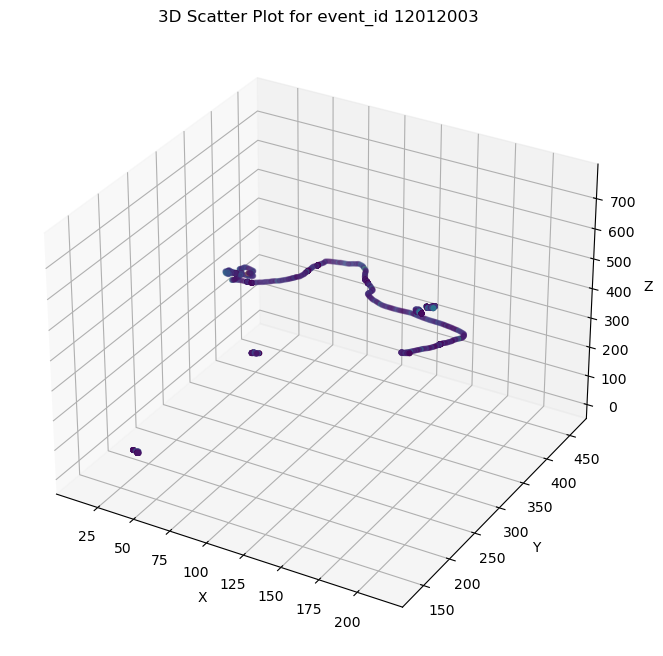

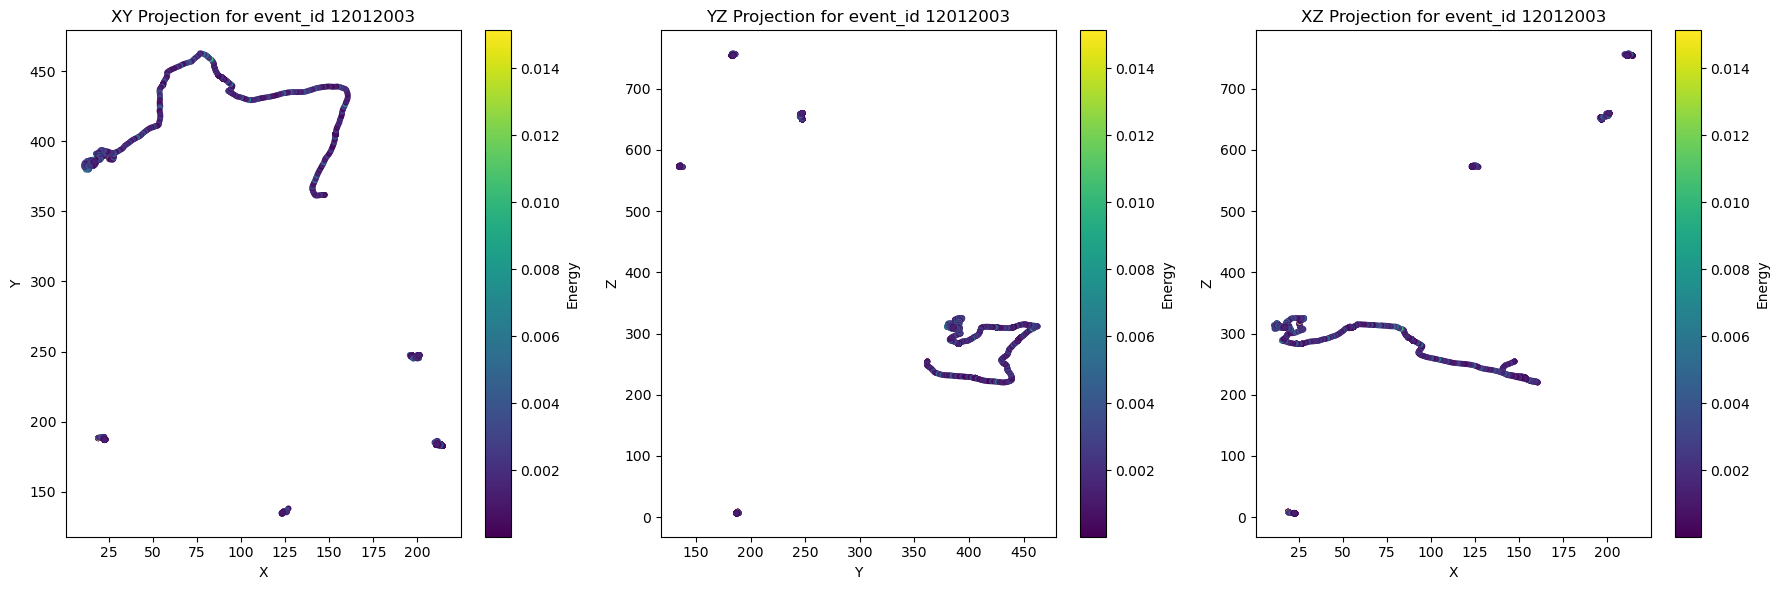

In [22]:
# Filter the hits_dst DataFrame for the specific event_id
specific_event = hits_dst.event.unique()[3]  # Replace with the desired event_id
event_hits = hits_dst[hits_dst['event'] == specific_event]

# Create a 3D scatter plot of the x, y, z coordinates
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(event_hits['X'], event_hits['Y'], event_hits['Z'], c=event_hits['E'], cmap='viridis', s=10)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Scatter Plot for event_id {specific_event}')

plt.show()

# Create subplots for xy, yz, and xz projections
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# XY projection
axs[0].scatter(event_hits['X'], event_hits['Y'], c=event_hits['E'], cmap='viridis', s=10)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title(f'XY Projection for event_id {specific_event}')
axs[0].colorbar = plt.colorbar(axs[0].collections[0], ax=axs[0], label='Energy')

# YZ projection
axs[1].scatter(event_hits['Y'], event_hits['Z'], c=event_hits['E'], cmap='viridis', s=10)
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Z')
axs[1].set_title(f'YZ Projection for event_id {specific_event}')
axs[1].colorbar = plt.colorbar(axs[1].collections[0], ax=axs[1], label='Energy')

# XZ projection
axs[2].scatter(event_hits['X'], event_hits['Z'], c=event_hits['E'], cmap='viridis', s=10)
axs[2].set_xlabel('X')
axs[2].set_ylabel('Z')
axs[2].set_title(f'XZ Projection for event_id {specific_event}')
axs[2].colorbar = plt.colorbar(axs[2].collections[0], ax=axs[2], label='Energy')

plt.tight_layout()
plt.show()

# extract the topology stuff

you have a couple of notebooks that do this.

In [23]:
def plot_voxels(df, base_vsize = 12):

    xs = df.X
    ys = df.Y
    zs = df.Z
    es = df.E

    the_hits = []
    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)
    
    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)
    
    vsizex = voxels[0].size[0]
    vsizey = voxels[0].size[1]
    vsizez = voxels[0].size[2]

    min_corner_x = min(v.X for v in voxels) - vsizex/2.
    min_corner_y = min(v.Y for v in voxels) - vsizey/2.
    min_corner_z = min(v.Z for v in voxels) - vsizez/2.

    
    x = [np.round(v.X/vsizex) for v in voxels]
    y = [np.round(v.Y/vsizey) for v in voxels]
    z = [np.round(v.Z/vsizez) for v in voxels]
    e = [v.E for v in voxels]

    x_min = int(min(x))
    y_min = int(min(y))
    z_min = int(min(z))

    x_max = int(max(x))
    y_max = int(max(y))
    z_max = int(max(z))

    VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
    #print(VOXELS.shape)

    # sort through the event set the "turn on" the hit voxels
    cmap = cm.viridis
    norm = Normalize(vmin=0, vmax=max(e))

    colors = np.empty(VOXELS.shape, dtype=object)
    for q in range(0,len(z)):
        VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
        colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

    # and plot everything
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    #a,b,c is spacing in mm needs an extra dim
    a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
    a = a*vsizex + min_corner_x
    b = b*vsizey + min_corner_y
    c = c*vsizez + min_corner_z

    # a, b, c are the corners of the voxels
    ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

    ax.set_xlabel('x (mm)')#,fontsize=16)
    ax.set_ylabel('y (mm)')#,fontsize=16)
    ax.set_zlabel('z (mm)')#,fontsize=16)


    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm)
    cb.set_label('Energy (keV)')

    fig.suptitle('voxelised_plot_two_tracks')

    #ax.view_init(-160, 90)

    plt.show(fig)



/tmp/ipykernel_25089/4035665741.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


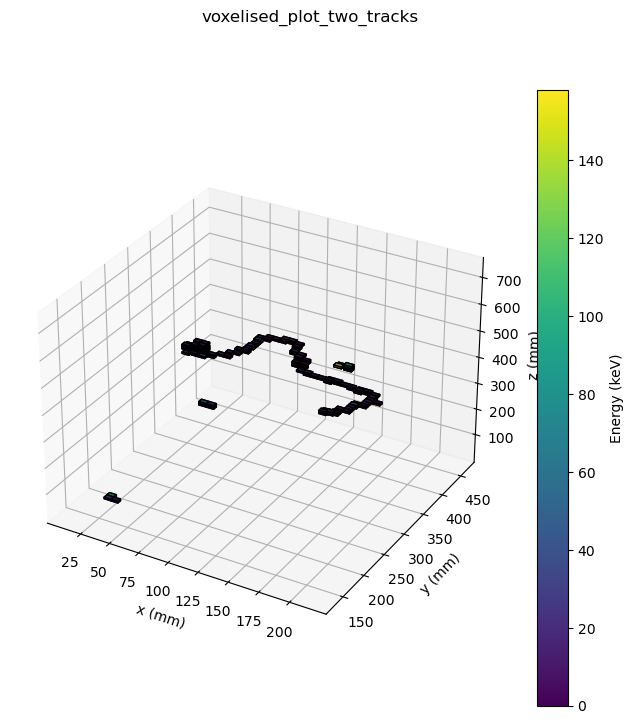

In [24]:
plot_voxels(event_hits, base_vsize = 6)

In [25]:
from IC.invisible_cities.types.ic_types          import         types_dict_tracks

df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
display(df)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z


In [26]:
topological_creator = track_blob_info_creator_extractor((6 * units.mm, 6 * units.mm, 6 * units.mm),
                                                        False,
                                                        0 * units.keV,
                                                        0,
                                                        27 * units.mm,
                                                        10000000000,
                                                        #scan_radius = 27 * units.mm
                                                        )



In [27]:
display(event_hits)

,event,particle_id,hit_id,X,Y,Z,time,E,label
3006,12012003,6,0,213.477234,183.626801,755.216125,1.748008,0.000327,ACTIVE
3007,12012003,41,0,213.477020,183.626648,755.216248,1.748079,0.000044,ACTIVE
3008,12012003,40,0,213.477097,183.626831,755.216248,1.748059,0.000047,ACTIVE
3009,12012003,39,0,213.477203,183.626816,755.216125,1.748017,0.000043,ACTIVE
3010,12012003,38,0,213.477173,183.626846,755.216370,1.748078,0.000047,ACTIVE
...,...,...,...,...,...,...,...,...,...
4633,12012003,80396,76,200.984924,247.316376,660.472900,3.295548,0.000163,ACTIVE
4634,12012003,80396,77,200.981827,247.319138,660.473022,3.295661,0.000037,ACTIVE
4635,12012003,80396,78,200.972626,247.325684,660.468506,3.295993,0.002265,ACTIVE
4636,12012003,80396,79,200.972366,247.325150,660.467773,3.296034,0.000175,ACTIVE


In [28]:
the_hits = []

xs = event_hits.X
ys = event_hits.Y
zs = event_hits.Z
es = event_hits.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)
base_vsize = 9
voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)
print(voxels)

[Voxel(15.211204549537776, 191.94882140288286, 10.156851992717684, E=51.95747939251305), Voxel(15.211204549537776, 378.44730995796965, 287.7038887143127, E=15.39233565563336), Voxel(15.211204549537776, 378.44730995796965, 305.610149147964, E=19.79572488926351), Voxel(15.211204549537776, 378.44730995796965, 314.56327936478965, E=85.07044654106721), Voxel(15.211204549537776, 387.32819036535477, 287.7038887143127, E=15.750809980090708), Voxel(15.211204549537776, 387.32819036535477, 296.6570189311384, E=17.575691279489547), Voxel(15.211204549537776, 387.32819036535477, 305.610149147964, E=90.10126141583896), Voxel(15.211204549537776, 387.32819036535477, 314.56327936478965, E=139.78603880605078), Voxel(15.211204549537776, 387.32819036535477, 323.51640958161533, E=4.450974054634571), Voxel(15.211204549537776, 396.2090707727399, 296.6570189311384, E=1.961318776011467), Voxel(15.211204549537776, 396.2090707727399, 323.51640958161533, E=3.677167696878314), Voxel(24.06182676812616, 183.067940995

In [29]:
# reshape to this
# data = pd.DataFrame(tr_1, columns = ['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'E', 'Ep'])
event_hits['npeak'] = 1
reshaped_hits = event_hits.rename(columns={'E': 'Ep'}).assign(Q=1)[['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'Ep']]
display(reshaped_hits)
reshaped_hits['E'] = reshaped_hits.Ep

/tmp/ipykernel_25089/3335319404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_hits['npeak'] = 1


,event,npeak,X,Y,Z,Q,Ep
3006,12012003,1,213.477234,183.626801,755.216125,1,0.000327
3007,12012003,1,213.477020,183.626648,755.216248,1,0.000044
3008,12012003,1,213.477097,183.626831,755.216248,1,0.000047
3009,12012003,1,213.477203,183.626816,755.216125,1,0.000043
3010,12012003,1,213.477173,183.626846,755.216370,1,0.000047
...,...,...,...,...,...,...,...
4633,12012003,1,200.984924,247.316376,660.472900,1,0.000163
4634,12012003,1,200.981827,247.319138,660.473022,1,0.000037
4635,12012003,1,200.972626,247.325684,660.468506,1,0.002265
4636,12012003,1,200.972366,247.325150,660.467773,1,0.000175


In [30]:
from typing import Dict

def hits_from_df (dst : pd.DataFrame, skip_NN : bool = False) -> Dict[int, HitCollection]:
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        print(event, time)
        display(df)
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int64(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                print('Skip NN continuing')
                continue
            if hasattr(row, 'Xrms'):
                print('Xrms found')
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                print('Xrms not found')
                Xrms = Xrms2 = 0
            if hasattr(row, 'Yrms'):
                print('Yrms found')
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                print('Yrms not found')
                Yrms = Yrms2 = 0
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )
            print(hit)
            hits.append(hit)
        print(hits)
        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)
        
    return all_events

In [31]:
times = getattr(event_hits, 'time', [-1]*len(event_hits))
#event_hits['time'] = -1


In [32]:
hits_lol = hits_from_df(reshaped_hits)
#print(hits_lol)
#print('='*10)
#print(hits_lol[12012002])


12012003 -1


,event,npeak,X,Y,Z,Q,Ep,E
3006,12012003,1,213.477234,183.626801,755.216125,1,0.000327,0.000327
3007,12012003,1,213.477020,183.626648,755.216248,1,0.000044,0.000044
3008,12012003,1,213.477097,183.626831,755.216248,1,0.000047,0.000047
3009,12012003,1,213.477203,183.626816,755.216125,1,0.000043,0.000043
3010,12012003,1,213.477173,183.626846,755.216370,1,0.000047,0.000047
...,...,...,...,...,...,...,...,...
4633,12012003,1,200.984924,247.316376,660.472900,1,0.000163,0.000163
4634,12012003,1,200.981827,247.319138,660.473022,1,0.000037,0.000037
4635,12012003,1,200.972626,247.325684,660.468506,1,0.002265,0.002265
4636,12012003,1,200.972366,247.325150,660.467773,1,0.000175,0.000175


Xrms not found
Yrms not found
<Hit : npeak = 1.0 z = 755.2161254882812 XYpeak = -1000, -1000 E = 0.0003266700077801943 Ec = -1 Ep = 0.0003266700077801943 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=213.47723388671875, y=183.62680053710938) 3dHit = Hit(213.47723388671875, 183.62680053710938, 755.2161254882812, E=0.0003266700077801943)  > >
Xrms not found
Yrms not found
<Hit : npeak = 1.0 z = 755.2162475585938 XYpeak = -1000, -1000 E = 4.447000173968263e-05 Ec = -1 Ep = 4.447000173968263e-05 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=213.47702026367188, y=183.62664794921875) 3dHit = Hit(213.47702026367188, 183.62664794921875, 755.2162475585938, E=4.447000173968263e-05)  > >
Xrms not found
Yrms not found
<Hit : npeak = 1.0 z = 755.2162475585938 XYpeak = -1000, -1000 E = 4.65299999632407e-05 Ec = -1 Ep = 4.65299999632407e-05 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=213.4770965576172, y=183.6268310546

In [ ]:
#if len(hits_lol[12012002].hits) > 1000000:
#    print('broke')

KeyError: 12012002

In [39]:
#print(hits_lol)
print(list(hits_lol.keys()))
print(hits_lol[list(hits_lol.keys())[0]])

[12012003]
HitCollectionHit list:<Hit : npeak = 1.0 z = 755.2161254882812 XYpeak = -1000, -1000 E = 0.0003266700077801943 Ec = -1 Ep = 0.0003266700077801943 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=213.47723388671875, y=183.62680053710938) 3dHit = Hit(213.47723388671875, 183.62680053710938, 755.2161254882812, E=0.0003266700077801943)  > ><Hit : npeak = 1.0 z = 755.2162475585938 XYpeak = -1000, -1000 E = 4.447000173968263e-05 Ec = -1 Ep = 4.447000173968263e-05 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=213.47702026367188, y=183.62664794921875) 3dHit = Hit(213.47702026367188, 183.62664794921875, 755.2162475585938, E=4.447000173968263e-05)  > ><Hit : npeak = 1.0 z = 755.2162475585938 XYpeak = -1000, -1000 E = 4.65299999632407e-05 Ec = -1 Ep = 4.65299999632407e-05 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=213.4770965576172, y=183.6268310546875) 3dHit = Hit(213.4770965576172, 183.6268310546875, 755.

In [ ]:
df, track_hitc, out_of_map = topological_creator(hits_lol[list(hits_lol.keys())[0]])

HitCollectionHit list:
[2.18462665e-05 1.99172599e-03 2.36104149e-03 2.20132130e-03
 2.47126166e-03 1.52263709e-03 1.39174040e-03 4.27252555e-04
 1.07302843e-03 1.76624837e-03 1.18507340e-03 4.60857200e-03
 1.64930231e-03 3.31321103e-03 1.14831387e-03 1.00820872e-03
 1.52234093e-03 1.77633017e-03 2.07686261e-03 1.35292381e-03
 2.10175780e-03 2.62982189e-03 1.27982022e-03 2.02455209e-03
 2.38403981e-03 1.48990704e-03 2.11679284e-03 2.65871146e-04
 1.18925225e-03 4.76897182e-03 2.50850734e-03 1.48470164e-03
 4.69611119e-03 1.31140137e-03 1.02549884e-03 1.95922330e-03
 1.27614965e-03 2.73342966e-03 2.69188778e-03 1.08963613e-04
 1.77316589e-03 2.18159729e-03 4.04497562e-03 2.64069485e-03
 2.79133138e-03 2.29975092e-03 4.28400375e-03 1.50808645e-03
 2.04326911e-03 2.33540637e-03 9.86758270e-04 5.91260009e-03
 7.26317568e-03 1.31046842e-03 2.40097684e-03 1.54648209e-03
 1.15190714e-03 1.96822546e-03 1.58853794e-03 1.90940697e-03
 2.26307730e-03 4.93357715e-04 5.70411049e-03 1.67835201e-03
 

no blob radius provided


In [19]:
display(df)
display(track_hitc)
print(df.columns)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,12012002,0,1.592507,310.131863,120,970,1,351.323883,-55.773937,708.112244,...,716.489434,428.746171,84.415861,800.734861,0.419359,0.313879,0.0,5.996284,5.922389,5.925278


HitCollectionHit list:<Hit : npeak = 1.0 z = 717.2938232421875 XYpeak = -1000, -1000 E = 0.0017011205200105906 Ec = -1 Ep = 0.0017011205200105906 trackid = 0 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=356.405029296875, y=-50.057003021240234) 3dHit = Hit(356.405029296875, -50.057003021240234, 717.2938232421875, E=0.0017011205200105906)  > ><Hit : npeak = 1.0 z = 716.4481201171875 XYpeak = -1000, -1000 E = 0.005104191601276398 Ec = -1 Ep = 0.005104191601276398 trackid = 0 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=356.5069580078125, y=-50.576629638671875) 3dHit = Hit(356.5069580078125, -50.576629638671875, 716.4481201171875, E=0.005104191601276398)  > ><Hit : npeak = 1.0 z = 715.6696166992188 XYpeak = -1000, -1000 E = 0.0014118829276412725 Ec = -1 Ep = 0.0014118829276412725 trackid = 0 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=356.8016052246094, y=-51.0997200012207) 3dHit = Hit(356.8016052246094, -51.0997200012207, 715.6696166992188, E=

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x',
       'vox_size_y', 'vox_size_z'],
      dtype='object')


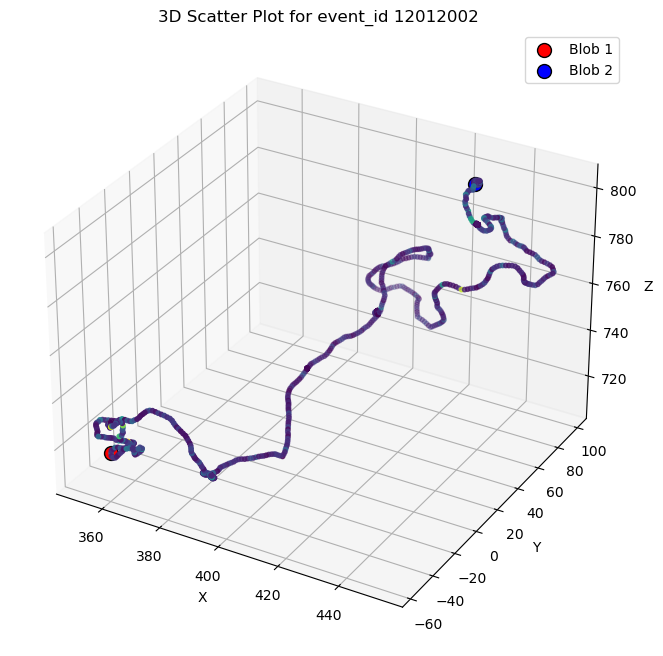

In [20]:
# Create a 3D scatter plot of the x, y, z coordinates
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_hits['X'], reshaped_hits['Y'], reshaped_hits['Z'], c=reshaped_hits['E'], cmap='viridis', s=10)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Scatter Plot for event_id {specific_event}')

# Plot the blob positions
ax.scatter(df['blob1_x'], df['blob1_y'], df['blob1_z'], c='red', label='Blob 1', s=100, edgecolor='k')
ax.scatter(df['blob2_x'], df['blob2_y'], df['blob2_z'], c='blue', label='Blob 2', s=100, edgecolor='k')

# Add legend
ax.legend()

plt.show()

/tmp/ipykernel_25089/4035665741.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


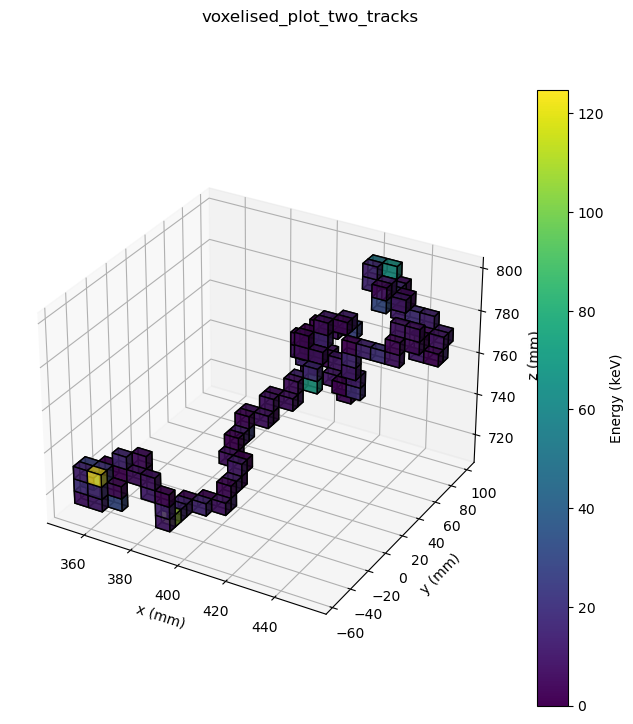

In [21]:
plot_voxels(event_hits, base_vsize = 6)